## Tweet Sentiment Extraction

#### Mini Project 3
- Email: yuehangdata@outlook.com
- Let's connect on LinkedIn: [Yue Hang Tan](https://www.linkedin.com/in/yuehangtan/)

## Data Source from Kaggle:
The data set was provided as a Kaggle competition which held in year 2020.

https://www.kaggle.com/competitions/tweet-sentiment-extraction/data

With over 20k rows of training data sets, it can help us to build some basic predictive models that could predict the sentiments of tweets, which can be useful for business applications such as find out the overall sentiment towards the product based on text reviews, identify the specific features of product that are frequently associated with negative sentiment, identify the trends, patterns or changes of sentiments towards the product over time, identify potential influencers (users with many followers) who have tweeted positively about the product, utilize the sentiment analysis results as features to build new ML model and predict the future sales trends etc.

In [1]:
# import system libraries
import os
import time
import warnings
warnings.filterwarnings("ignore")

# import NLP and regex libraries
import spacy
import nltk
import re

# import standard data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

# Import text vectorizer and data processing libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn import metrics
from tensorflow.keras.metrics import Recall
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Import ML models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [4]:
df = pd.read_csv("train.csv")
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


### 1. EDA and data cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [6]:
# There seems to be a text row where it is NaN
df.isna().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [7]:
# Identify the row with NaN value in column "text"
df[df["text"].isna()]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [8]:
# Drop this row
df.drop(index=314, axis=0, inplace=True)

# Inspect the df again
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [9]:
# Drop the "selected_text" and "textID" columns. We will do the text cleaning by ourselves
df.drop(["selected_text", "textID"], axis=1, inplace=True)
df.head(3)

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative


In [10]:
# Define a function to perform data (text) cleaning
def text_clean(df, text):
    """ 
    Note: Make sure to check if there is any float/int contained in the DataFrame before using this function.
    If the df contains any float/int, preprocess it beforehand.
    1. Input a DataFrame with text to be cleaned.
    2. Input the header of the text column
    """
    # Load English tokenizer, tagger, parser, NER and word vectors
    nlp = spacy.load("en_core_web_sm")

    # Change all the text into lower case
    df["Lower Case"] = df[text].apply(lambda x: x.lower() if type(x) == str else x)

    # Remove all the punctuations in the text
    df["Punctuations Removed"] = df["Lower Case"].apply(lambda x: re.sub("\W", " ", x) if type(x) == str else x)

    # Remove multi-spacing and new line into just single-spacing
    df["Spaces Cleaned"] = df["Punctuations Removed"].apply(lambda x: re.sub(r"(\s{2,}|\n{2,})", " ", x))

    # Return the number of characters, excluding spaces
    df["Char Counts"] = df["Punctuations Removed"].apply(lambda x: len([x for item in x if item != " "]))

    # Remove stop words
    df["No Stop Words"] = df["Spaces Cleaned"].apply(lambda x: " ".join(token.text for token in nlp(x) if token.is_stop == False))

    # Lemmatize the strings
    df["Lemmatized"] = df["No Stop Words"].apply(lambda x: " ".join(token.lemma_ for token in nlp(x.strip())))

    # Tokenize the lemmatized string and store in a list, for text vectorization purposes
    df["Tokenized"] = df["Lemmatized"].apply(lambda x: [item for item in nlp(x.strip())])

    # Return the count of words
    df["Word Counts"] = df["Spaces Cleaned"].apply(lambda x: len(x.split()))

    # Word density (average number of characters in a word)
    df["Word Density"] = df["Char Counts"] / df["Word Counts"]

    # Punctuation Counts
    df["Punctuation Counts"] = df["Lower Case"].apply(lambda x: len([item for item in x if item in string.punctuation]))

    # Remove the leading and trailing space(s), and return the tokenized text
    df["Tokenized"] = df["Lemmatized"].apply(lambda x: [item.text for item in nlp(x.strip())])
    df.head()

    return df

In [11]:
%%time
# Preview the cleaned DataFrame
df_cleaned = text_clean(df, "text")
df_cleaned.head()

CPU times: total: 9min 16s
Wall time: 11min 6s


,text,sentiment,Lower Case,Punctuations Removed,Spaces Cleaned,Char Counts,No Stop Words,Lemmatized,Tokenized,Word Counts,Word Density,Punctuation Counts
0,"I`d have responded, if I were going",neutral,"i`d have responded, if i were going",i d have responded if i were going,i d have responded if i were going,27,d responded going,d respond go,"[d, respond, go]",8,3.375000,2
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad i will miss you here in san diego!!!,sooo sad i will miss you here in san diego,sooo sad i will miss you here in san diego,33,sooo sad miss san diego,sooo sad miss san diego,"[sooo, sad, miss, san, diego]",10,3.300000,3
2,my boss is bullying me...,negative,my boss is bullying me...,my boss is bullying me,my boss is bullying me,18,boss bullying,boss bully,"[boss, bully]",5,3.600000,3
3,what interview! leave me alone,negative,what interview! leave me alone,what interview leave me alone,what interview leave me alone,25,interview leave,interview leave,"[interview, leave]",5,5.000000,1
4,"Sons of ****, why couldn`t they put them on t...",negative,"sons of ****, why couldn`t they put them on t...",sons of why couldn t they put them on t...,sons of why couldn t they put them on the rel...,55,sons couldn t releases bought,son couldn t release buy,"[son, couldn, t, release, buy]",14,3.928571,6


In [12]:
# Check the DataFrame information
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  27480 non-null  object 
 1   sentiment             27480 non-null  object 
 2   Lower Case            27480 non-null  object 
 3   Punctuations Removed  27480 non-null  object 
 4   Spaces Cleaned        27480 non-null  object 
 5   Char Counts           27480 non-null  int64  
 6   No Stop Words         27480 non-null  object 
 7   Lemmatized            27480 non-null  object 
 8   Tokenized             27480 non-null  object 
 9   Word Counts           27480 non-null  int64  
 10  Word Density          27478 non-null  float64
 11  Punctuation Counts    27480 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 2.7+ MB


In [13]:
# There seems to be two missing values in Word Density.
# Check what are these two rows
df_cleaned[df_cleaned["Word Density"].isna()]

,text,sentiment,Lower Case,Punctuations Removed,Spaces Cleaned,Char Counts,No Stop Words,Lemmatized,Tokenized,Word Counts,Word Density,Punctuation Counts
8120,****,negative,****,,,0,,,[],0,NaN,4
26005,?,neutral,?,,,0,,,[],0,NaN,1


In [14]:
# Apparently the text of these two rows only consist of meaningless symbols, hence there is no word counts
# Drop these two rows
df_cleaned.drop(index=[8120, 26005], axis=0, inplace=True)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27478 entries, 0 to 27480
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  27478 non-null  object 
 1   sentiment             27478 non-null  object 
 2   Lower Case            27478 non-null  object 
 3   Punctuations Removed  27478 non-null  object 
 4   Spaces Cleaned        27478 non-null  object 
 5   Char Counts           27478 non-null  int64  
 6   No Stop Words         27478 non-null  object 
 7   Lemmatized            27478 non-null  object 
 8   Tokenized             27478 non-null  object 
 9   Word Counts           27478 non-null  int64  
 10  Word Density          27478 non-null  float64
 11  Punctuation Counts    27478 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 2.7+ MB


### 2. Process and split the data

In this notebook the objective is to use conventional ML models, and the workflow is as follow:
1. Vectorize features with TF-IDF.
2. One-hot encode target variable.
3. Split the data into train, validation, and test data sets.

In [15]:
# Preview the DataFrame
df_cleaned.head(3)

,text,sentiment,Lower Case,Punctuations Removed,Spaces Cleaned,Char Counts,No Stop Words,Lemmatized,Tokenized,Word Counts,Word Density,Punctuation Counts
0,"I`d have responded, if I were going",neutral,"i`d have responded, if i were going",i d have responded if i were going,i d have responded if i were going,27,d responded going,d respond go,"[d, respond, go]",8,3.375,2
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad i will miss you here in san diego!!!,sooo sad i will miss you here in san diego,sooo sad i will miss you here in san diego,33,sooo sad miss san diego,sooo sad miss san diego,"[sooo, sad, miss, san, diego]",10,3.300,3
2,my boss is bullying me...,negative,my boss is bullying me...,my boss is bullying me,my boss is bullying me,18,boss bullying,boss bully,"[boss, bully]",5,3.600,3


2.1 Vectorize the text data

In [16]:
# Instantiate TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Vectorize the "Lemmatized" text data with TF-IDF
X_vectorized = vectorizer.fit_transform(df["Lemmatized"])

# Convert the vectorized text into dense matrix
X_dense = X_vectorized.toarray()

X = X_dense

In [17]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
# Return the target variable
y = df_cleaned["sentiment"].to_frame()
y.head()

,sentiment
0,neutral
1,negative
2,negative
3,negative
4,negative


2.2 One-hot encode the target variable

In [20]:
# One-hot encode the target
y = pd.get_dummies(y["sentiment"])
y[:5]

,negative,neutral,positive
0,False,True,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False


In [21]:
# Check if both X and y share the same length
if len(X) == len(y):
    print(f"The length of X {len(X)} is the same as the length of y {len(y)}. Proceed to the next step.")
else:
    print(f"The length of X {len(X)} is NOT the same as the length of y {len(y)}. Check the input data.")

The length of X 27478 is the same as the length of y 27478. Proceed to the next step.


2.3 Spit the data into training, validation and test data

In [22]:
# Split X and y into train, validation, and test data sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, shuffle=True, random_state=42)

In [23]:
# Preview the shape of the split data sets
pd.DataFrame({
    "X_train": [X_train.shape],
    "y_train": [y_train.shape],
    "X_val": [X_val.shape],
    "y_val": [y_val.shape],
    "X_test": [X_test.shape],
    "y_test": [y_test.shape]
})

,X_train,y_train,X_val,y_val,X_test,y_test
0,"(17585, 22723)","(17585, 3)","(4397, 22723)","(4397, 3)","(5496, 22723)","(5496, 3)"


### 3. ML Modelling with dense neural networks

In [24]:
# Instantiate and add dense layers to the model
model = Sequential()
model.add(Dense(100, activation="relu", input_dim=22723))
model.add(Dense(3, activation="softmax"))

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=[Recall(name="recall")])

In [25]:
print(f"Length of X is {len(X)} and length of y is {len(y)}")

if len(X) == len(y):
    print("Their lengths are equal")
else:
    print("Not equal! Check the data again...")

Length of X is 27478 and length of y is 27478
Their lengths are equal


In [26]:
# Specify the location to save the weights
checkpoint = ModelCheckpoint("best_model_2", monitor="val_recall", verbose=1, save_best_only=True, mode="max")

In [28]:
%%time
fitting = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[checkpoint])

Epoch 1/2
550/550 [==============================] - ETA: 0s - loss: 0.8562 - recall: 0.3514
Epoch 1: val_recall improved from -inf to 0.59086, saving model to best_model_2
INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


550/550 [==============================] - 38s 52ms/step - loss: 0.8562 - recall: 0.3514 - val_loss: 0.7434 - val_recall: 0.5909
Epoch 2/2
549/550 [============================>.] - ETA: 0s - loss: 0.5365 - recall: 0.7581
Epoch 2: val_recall improved from 0.59086 to 0.63361, saving model to best_model_2
INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


550/550 [==============================] - 24s 44ms/step - loss: 0.5366 - recall: 0.7580 - val_loss: 0.7706 - val_recall: 0.6336
CPU times: total: 3min 2s
Wall time: 1min 10s


### 4. Evaluate the model

4.1 Recall and Loss over Epochs

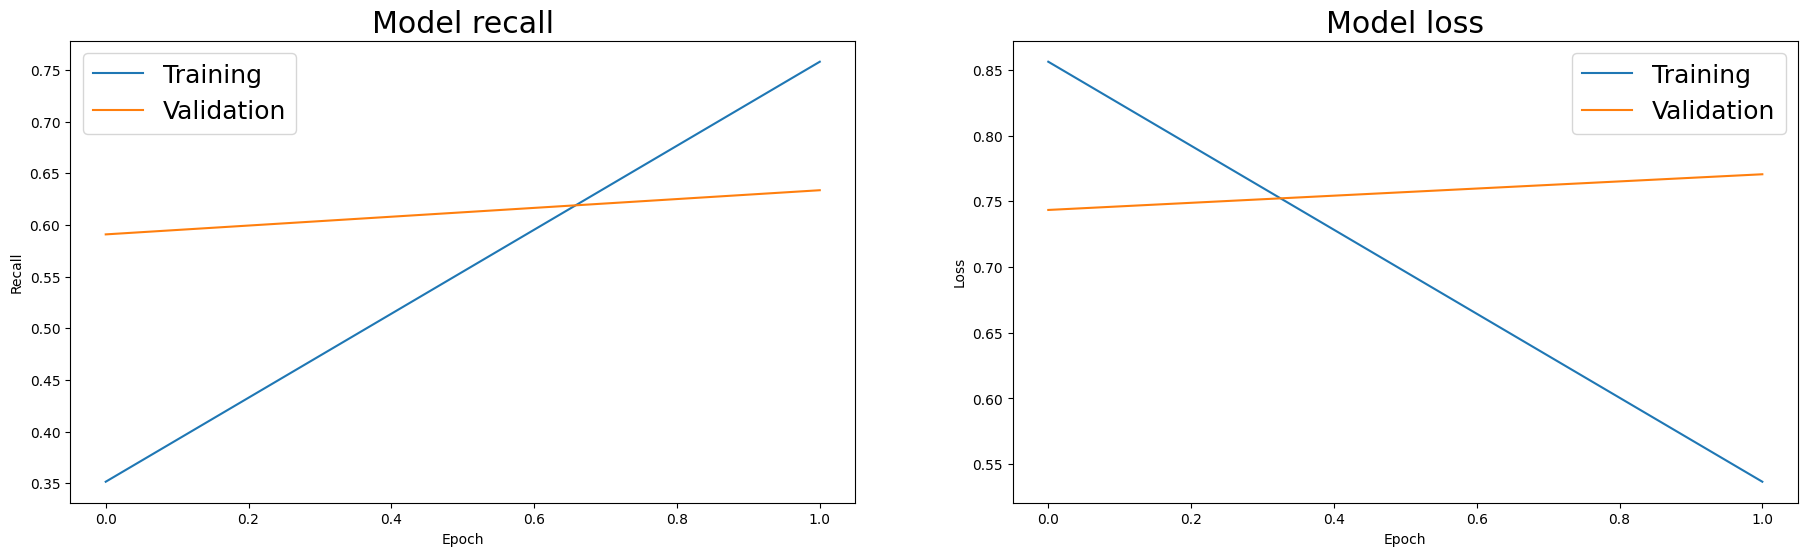

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

plt.rcParams.update({'font.size': 18})

# Plot training & validation accuracy values
ax[0].plot(fitting.history['recall'], label = 'Training')
ax[0].plot(fitting.history['val_recall'], label = 'Validation')
ax[0].set_title('Model recall')
ax[0].set_ylabel('Recall')
ax[0].set_xlabel('Epoch')
ax[0].legend()

# Plot training & validation loss values
ax[1].plot(fitting.history['loss'], label = 'Training')
ax[1].plot(fitting.history['val_loss'], label = 'Validation')
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend()

plt.show()

4.2 Compute the Metrics

In [30]:
# Return the mbest model
model = load_model("best_model_2")

In [31]:
y_pred_test = model.predict(X_test)

172/172 [==============================] - 1s 3ms/step


In [32]:
y_pred_test

array([[2.71307677e-02, 1.03244349e-01, 8.69624794e-01],
       [1.49950655e-02, 4.89382558e-02, 9.36066628e-01],
       [2.75431186e-01, 5.83592474e-01, 1.40976325e-01],
       ...,
       [2.82857835e-01, 3.99510145e-01, 3.17631990e-01],
       [4.06025708e-01, 5.11120439e-01, 8.28538910e-02],
       [1.88938182e-04, 8.51221755e-03, 9.91298854e-01]], dtype=float32)

y_pred_test is in probability now, which doesn't work for some functions like confusion matrix.

Convert both y_test and y_pred_test into multi-class arrays to become easier to work with.

In [33]:
# Both y_pred and y_test are one-hot encoded arrays, which may not work for certain processing like confusion matrix
# Therefore convert both y_pred and y_test into multiclass arrays
y_pred_multiclass = np.argmax(y_pred_test, axis=1)
y_test_multiclass = np.argmax(y_test, axis=1)

In [34]:
# Compute accuracy score
accuracy_test = accuracy_score(y_test_multiclass, y_pred_multiclass)
accuracy_test

0.6635735080058224

In [35]:
# Compute precision score
precision_test = precision_score(y_test_multiclass, y_pred_multiclass, average="macro")
precision_test

0.6718498095200068

In [36]:
# Compute recall score
recall_test = recall_score(y_test_multiclass, y_pred_multiclass, average="macro")
recall_test

0.6644855170495821

In [37]:
# Compute F1 score
f1_test = f1_score(y_test_multiclass, y_pred_multiclass, average="macro")
f1_test

0.6664205710281476

In [38]:
y_score = model.predict(X_test)

172/172 [==============================] - 1s 3ms/step


In [39]:
final_results = pd.DataFrame({
    "Accuracy": [accuracy_test],
    "Precision": [precision_test],
    "Recall": [recall_test],
    "F1": [f1_test]
}, index=["Score"])

final_results

,Accuracy,Precision,Recall,F1
Score,0.663574,0.67185,0.664486,0.666421


4.3 ROC Curve

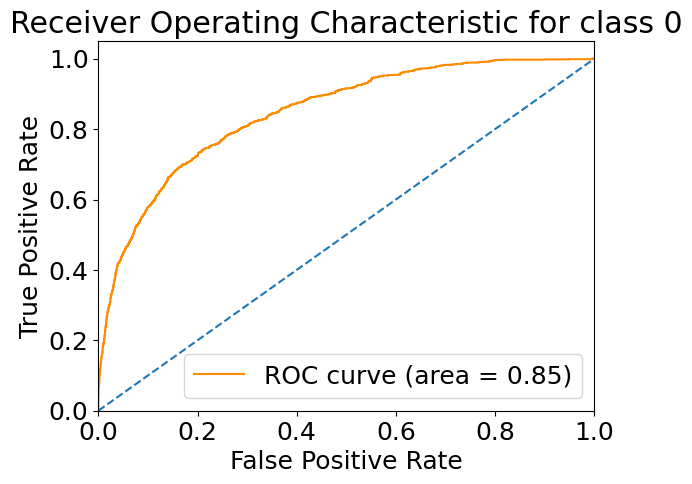

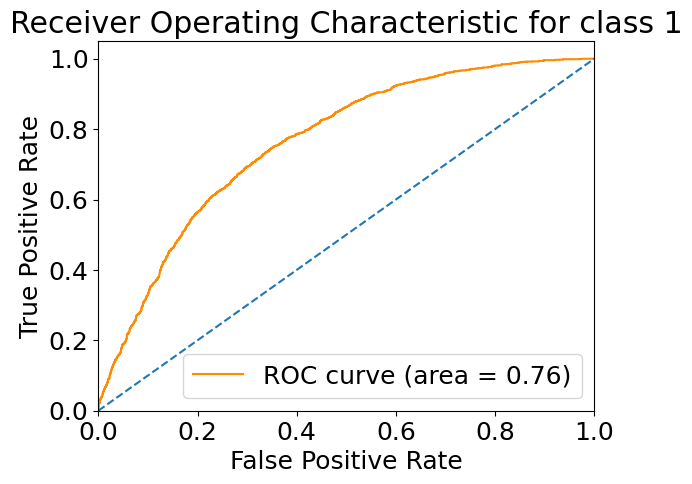

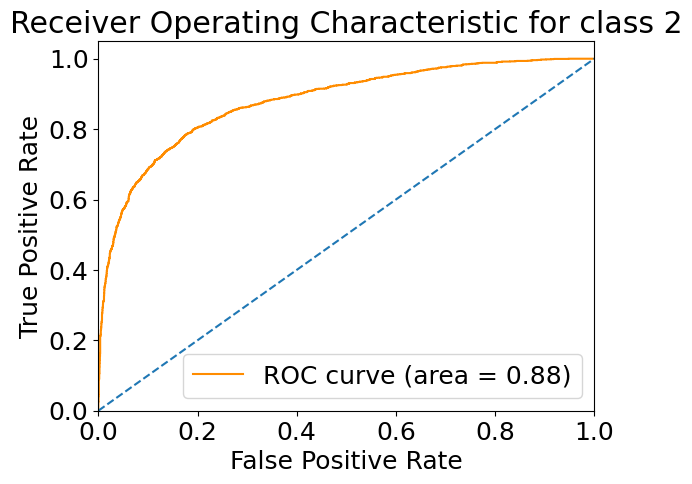

In [42]:
# Credits: Copilot
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# y_score is the output of predict_proba()

# Binarize the output
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color="darkorange", label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class %i' % i)
    plt.legend(loc="lower right")
    plt.show()


In [45]:
# Preview y_test in multi-class
y_test_multiclass

array([2, 2, 1, ..., 1, 0, 2], dtype=int64)

In [46]:
# Preview y_pred in multi-class
y_pred_multiclass

array([2, 2, 1, ..., 1, 1, 2], dtype=int64)

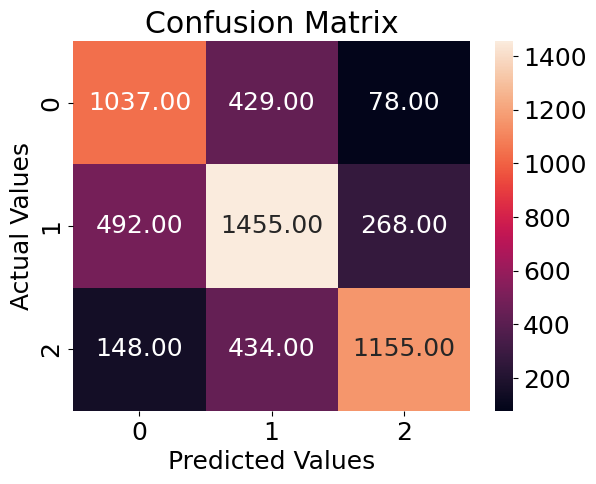

In [47]:
# Now we can compute the confusion matrix.
# Credits: Copilot
cf = pd.DataFrame(confusion_matrix(y_test_multiclass, y_pred_multiclass))
sns.heatmap(data=cf, annot=True, fmt=".2f")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Confusion Matrix")
plt.show();

#### Discussions:
#### 1. Check out the PowerPoint presentation slide deck for more discussions and comparisons on the models and analysis.